# **Quora Question Pair Similarity - Part 2**


> * **Data Preprocessing**
> * **Model Building using Classification algorithms.**
> * **MLOps** 

### **Description**

**About Quora** :	
* Quora is a social question-and-answer platform to ask questions and connect with people who contribute unique insights and quality answers. Users can collaborate by editing questions and commenting on answers that have been submitted by other users.
    
* One of the major problems that Quora face is the duplication of questions. Duplication of question ruins the experience for both the questioner and the answerer. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. 


### **Problem Statement:**
* Identify which questions asked on Quora are duplicates of questions that have already been asked.

* This can be helpful for providing instant responses to questions that have already been addressed.

### **Objective:**
* To predict which of the provided pairs of questions contain two questions with the same meaning. 








In [1]:
!gdown 1Mvz5Jc2y3VPtbwbJ51fAiiMLRD5KZ9pB
#https://drive.google.com/file/d/1Mvz5Jc2y3VPtbwbJ51fAiiMLRD5KZ9pB/view?usp=sharing

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import distance
from fuzzywuzzy import fuzz

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
feature_df = pd.read_csv('data.csv')

In [4]:
# Null values check
feature_df.isnull().sum()

Unnamed: 0              0
id                      0
qid1                    0
qid2                    0
is_duplicate            0
q1_lem                  0
q1_len                  0
q1_num_words            0
q2_lem                  0
q2_len                  0
q2_num_words            0
word_common             0
word_total              0
word_share              0
cwc_min                 0
cwc_max                 0
csc_min                 0
csc_max                 0
ctc_min                 0
ctc_max                 0
first_word_eq           0
last_word_eq            0
abs_len_diff            0
mean_len                0
longest_substr_ratio    0
fuzz_ratio              0
fuzz_partial_ratio      0
token_sort_ratio        0
token_set_ratio         0
dtype: int64

In [5]:
feature_df.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'is_duplicate', 'q1_lem', 'q1_len',
       'q1_num_words', 'q2_lem', 'q2_len', 'q2_num_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff',
       'mean_len', 'longest_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [6]:
feature_df.rename(columns={'q1_lem':'Clean_q1_lem','q2_lem':'Clean_q2_lem'},inplace=True)

In [7]:
final_df = feature_df.drop(columns=['Unnamed: 0','id','qid1','qid2','Clean_q1_lem','Clean_q2_lem'])
print(final_df.shape)
final_df.head()

(4000, 23)


,is_duplicate,q1_len,q1_num_words,q2_len,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,33,8,33,8,7,16,0.44,0.833319,0.833319,...,0.874989,1,0,0,8.0,0,88,88,81,90
1,0,52,11,50,9,6,20,0.30,0.499992,0.499992,...,0.545450,1,0,2,10.0,0,73,72,73,73
2,0,95,17,44,8,2,25,0.08,0.000000,0.000000,...,0.124999,0,0,8,12.0,0,35,43,36,24
3,1,43,7,51,9,6,16,0.38,0.666656,0.666656,...,0.444440,1,0,2,8.0,0,72,67,89,96
4,1,37,9,28,7,4,16,0.25,0.399992,0.333328,...,0.222220,1,0,2,8.0,0,68,61,71,81


In [8]:
final_df.isnull().sum()

is_duplicate            0
q1_len                  0
q1_num_words            0
q2_len                  0
q2_num_words            0
word_common             0
word_total              0
word_share              0
cwc_min                 0
cwc_max                 0
csc_min                 0
csc_max                 0
ctc_min                 0
ctc_max                 0
first_word_eq           0
last_word_eq            0
abs_len_diff            0
mean_len                0
longest_substr_ratio    0
fuzz_ratio              0
fuzz_partial_ratio      0
token_sort_ratio        0
token_set_ratio         0
dtype: int64

In [9]:
ques_df = feature_df[['Clean_q1_lem','Clean_q2_lem']]
ques_df.head()
# df for BoW
ques_df_bow=ques_df
# df for TF-IDF
ques_df_tfidf=ques_df
# df for w2v
ques_df_w2v=ques_df
# df for Glove
ques_df_glove=ques_df
# df for Bert
ques_df_bert=ques_df

questions= ques_df['Clean_q1_lem']+ques_df['Clean_q2_lem']

# **Bag of Words approach  using Count Vectorizer**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['Clean_q1_lem']) + list(ques_df['Clean_q2_lem'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(4000, 6000)

In [11]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

final_df_bow=final_df

final_df_tfidf=final_df

final_df_w2v=final_df

final_df_glove=final_df

final_df_bert=final_df

(4000, 6023)


In [12]:
#Data Preparation - Split the data into train and test set

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [13]:
print('X_train :',X_train.shape,'  y_train :',y_train.shape)
print('X_test :',X_test.shape,'  y_test :',y_test.shape)

X_train : (3200, 6022)   y_train : (3200,)
X_test : (800, 6022)   y_test : (800,)


In [14]:

"""# ML-FLow"""
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Quora_Question_Pair_Similarity")


2023/06/09 22:29:00 INFO mlflow.tracking.fluent: Experiment with name 'Quora_Question_Pair_Similarity' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Desktop/EDA/EDA/mlruns/2', creation_time=1686329940813, experiment_id='2', last_update_time=1686329940813, lifecycle_stage='active', name='Quora_Question_Pair_Similarity', tags={}>

## **Logistic Regression**

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred_log=lr.predict(X_test)
print('Accuracy for Log.Regn : ',accuracy_score(y_test,y_pred_log))

Accuracy for Log.Regn :  0.72125


## **Random Forest**

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print('Accuracy for Random Forest : ',accuracy_score(y_test,y_pred_rf))

Accuracy for Random Forest :  0.755


## **XGBoost**

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
print('Accuracy for XGBoost : ',accuracy_score(y_test,y_pred_xgb))

Accuracy for XGBoost :  0.73125


## **Support Vector Machine**

In [18]:
from sklearn.svm import SVC

svc=SVC()
svc.fit(X_train,y_train)
y_pred_svc=svc.predict(X_test)
print('Accuracy for SVM classifier : ',accuracy_score(y_test,y_pred_svc))

Accuracy for SVM classifier :  0.66625


In [19]:
# initialize list elements
data = [['Logistic Regression', accuracy_score(y_test,y_pred_log)],['Random Forest',accuracy_score(y_test,y_pred_rf)] ,[ "XGBoost", accuracy_score(y_test,y_pred_xgb)] ,[ "Supprt Vector Machine",accuracy_score(y_test,y_pred_svc)]]
  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data, columns=['Model','Accuracy'])
print("For Bag of Words approach:")
df

For Bag of Words approach:


,Model,Accuracy
0,Logistic Regression,0.72125
1,Random Forest,0.75500
2,XGBoost,0.73125
3,Supprt Vector Machine,0.66625


The accuracy score of Random Forest is better compared to other models.

In [20]:
# Analysis of confusion matrix for Random forest model
from sklearn.metrics import confusion_matrix

# for random forest model
confusion_matrix(y_test,y_pred_rf)

array([[421,  74],
       [122, 183]], dtype=int64)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       495
           1       0.71      0.60      0.65       305

    accuracy                           0.76       800
   macro avg       0.74      0.73      0.73       800
weighted avg       0.75      0.76      0.75       800



In [22]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1,'lem')
    q2 = preprocess(q2,'lem')
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))



In [23]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [24]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

In [25]:
# preprocessing function
def preprocess(q, flag):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        q = stemmer.stem(q)
    else:
        q = lemmatizer.lemmatize(q)
        
    return q


In [26]:
rf.predict(query_point_creator(q1,q4))

array([1], dtype=int64)

In [27]:
import pickle

pickle.dump(rf,open('mlruns/model.pkl','wb'))
pickle.dump(cv,open('mlruns/cv.pkl','wb'))

In [28]:
# Tracking-Experiment-Logistic_regression

from sklearn import metrics

with mlflow.start_run(nested=True):
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "Logit")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    lr_classifier_bow = LogisticRegression(C=C)
    lr_classifier_bow.fit(X_train, y_train)
    y_pred = lr_classifier_bow.predict(X_test)
   
    acc = metrics.accuracy_score(y_test, y_pred)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(lr_classifier_bow, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/cv.pkl")




In [29]:
# Tracking-Experiment - Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "rf_bow")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    rf_bow = RandomForestClassifier()
    rf_bow.fit(X_train,y_train)
    y_pred = rf_bow.predict(X_test)
    accuracy_score(y_test,y_pred)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(rf_bow, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/cv.pkl")

In [30]:
# Tracking -Experiment -SVM

from sklearn.svm import SVC

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "SVM_bow")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    sv_classifier_bow = SVC(C=C)
    sv_classifier_bow.fit(X_train, y_train)
    y_pred = sv_classifier_bow.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(sv_classifier_bow, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/cv.pkl")

# **TF - IDF approach using TfidfVectorizer**

In [31]:
questions = list(ques_df['Clean_q1_lem']) + list(ques_df['Clean_q2_lem'])

# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(questions)
q1_arr, q2_arr = np.vsplit(vectorizer.fit_transform(questions).toarray(),2)
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(4000, 18362)

In [32]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(4000, 24385)


,is_duplicate,q1_len,q1_num_words,q2_len,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,9171,9172,9173,9174,9175,9176,9177,9178,9179,9180
0,0,33,8,33,8,7,16,0.44,0.833319,0.833319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,52,11,50,9,6,20,0.30,0.499992,0.499992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,95,17,44,8,2,25,0.08,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,43,7,51,9,6,16,0.38,0.666656,0.666656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,37,9,28,7,4,16,0.25,0.399992,0.333328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

pickle.dump(vectorizer,open('mlruns/vectorizer.pkl','wb'))
pd.DataFrame(dtm.toarray(), columns=sorted(vectorizer.vocabulary_)).head()

,00,000,00k,012,034,09,0a,0v,0x0c0007,10,...,α2,خلوة,سعيد,سنة,عيد,مولد,学位课,必修课,选修课,鹵水
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Logistic regression**

In [34]:
# Logistic Regression for TF-IDF
lr_classifier_tfidf = LogisticRegression(C=C)
lr_classifier_tfidf.fit(X_train, y_train)
y_pred_log = lr_classifier_tfidf.predict(X_test)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       495
           1       0.67      0.55      0.61       305

    accuracy                           0.73       800
   macro avg       0.71      0.69      0.70       800
weighted avg       0.72      0.72      0.72       800



**Random Forest**

In [35]:
# Random forest for TF-IDF
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train,y_train)
y_pred_rf = rf_tfidf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.74      0.88      0.81       495
           1       0.72      0.51      0.60       305

    accuracy                           0.74       800
   macro avg       0.73      0.69      0.70       800
weighted avg       0.73      0.74      0.73       800



**Support vector Machine**

In [36]:
# SVC for TF-IDF
sv_classifier_tfidf = SVC(C=C)
sv_classifier_tfidf.fit(X_train, y_train)
y_pred_svc = sv_classifier_tfidf.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       495
           1       0.56      0.50      0.52       305

    accuracy                           0.66       800
   macro avg       0.63      0.63      0.63       800
weighted avg       0.65      0.66      0.65       800



**XGBoost**

In [37]:
xgb_tfidf = XGBClassifier()
xgb_tfidf.fit(X_train,y_train)
y_pred_xgb = xgb_tfidf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       495
           1       0.68      0.58      0.63       305

    accuracy                           0.74       800
   macro avg       0.72      0.71      0.71       800
weighted avg       0.73      0.74      0.73       800



In [38]:
# initialize list elements
data = [['Logistic Regression', accuracy_score(y_test,y_pred_log)],['Random Forest',accuracy_score(y_test,y_pred_rf)] ,[ "XGBoost", accuracy_score(y_test,y_pred_xgb)] ,[ "Support Vector Machine",accuracy_score(y_test,y_pred_svc)]]
  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data, columns=['Model','Accuracy'])
print("For TF - IDF approach:")
df

For TF - IDF approach:


,Model,Accuracy
0,Logistic Regression,0.72500
1,Random Forest,0.73750
2,XGBoost,0.73625
3,Support Vector Machine,0.65750


The accuracy score of Random Forest is better compared to other models.

In [39]:
# Analysis of confusion matrix for Random forest model
from sklearn.metrics import confusion_matrix

# for random forest model
confusion_matrix(y_test,y_pred_rf)

array([[435,  60],
       [150, 155]], dtype=int64)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.74      0.88      0.81       495
           1       0.72      0.51      0.60       305

    accuracy                           0.74       800
   macro avg       0.73      0.69      0.70       800
weighted avg       0.73      0.74      0.73       800



In [41]:
# Experiment Tracking for TFIDF Logistic Regression

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "Logit_tfidf")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    lr_classifier_tfidf = LogisticRegression(C=C)
    lr_classifier_tfidf.fit(X_train, y_train)
    y_pred = lr_classifier_tfidf.predict(X_test)
   
    acc = accuracy_score(y_test, y_pred)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(lr_classifier_tfidf, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/vectorizer.pkl")

In [42]:
# Experiment Tracking for TFIDF Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "rf_tfidf")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    rf_tfidf = RandomForestClassifier()
    rf_tfidf.fit(X_train,y_train)
    y_pred = rf_tfidf.predict(X_test)
    acc=accuracy_score(y_test,y_pred)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(rf_tfidf, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/vectorizer.pkl")

In [43]:
# Experiment Tracking

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "xgboost_tfidf")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    xgb_tfidf = XGBClassifier()
    xgb_tfidf.fit(X_train,y_train)
    y_pred_xgb = xgb_tfidf.predict(X_test)
    accuracy_score(y_test,y_pred_xgb)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(xgb_tfidf, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/vectorizer.pkl")

In [44]:
# Experiment Tracking for TFIDF SVM

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "SVM_tfidf")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    sv_classifier_tfidf = SVC(C=C)
    sv_classifier_tfidf.fit(X_train, y_train)
    y_pred = sv_classifier_tfidf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(sv_classifier_tfidf, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/vectorizer.pkl")

# **Word2Vec approach**

In [45]:
import gensim
# print(gensim.__version__)
from gensim.models import Word2Vec

In [46]:
questions = list(ques_df['Clean_q1_lem']) + list(ques_df['Clean_q2_lem'])
isduplicate=list(final_df['is_duplicate'])+list(final_df['is_duplicate'])

questions=pd.DataFrame(questions)
isdup=pd.DataFrame(isduplicate)
questions.columns=['questions']
# questions['questions']
questions['questions'] = questions['questions'].apply(lambda sent : sent.split())
questions.head(3)

,questions
0,"[how, do, i, play, pokémon, go, in, korea]"
1,"[what, are, some, of, the, best, side, dishes,..."
2,"[which, is, more, advisable, and, better, mate..."


In [47]:
model_w2v = Word2Vec(list(questions['questions']), vector_size=100, min_count=1)
model_w2v

In [48]:
# fn to create word vector from document
def document_vector(doc, keyed_vectors):
    """Remove out-of-vocabulary words. Create document vectors by averaging word vectors."""
    vocab_tokens = [word for word in doc if word in keyed_vectors.index_to_key]
    return np.mean(keyed_vectors.__getitem__(vocab_tokens), axis=0)

In [49]:
questions['doc_vector'] = questions.questions.apply(lambda x : document_vector(x, model_w2v.wv))
# questions['doc_vector']
X_train_w2v = list(questions['doc_vector'])

#questionsw['is_duplicate']=pd.cocafinal_df['is_duplicate']
questions.insert(1, "is_duplicate", isdup , True)
questions['doc_vector'].head(3)

0    [-0.11916832, 0.8949467, -0.016978435, 0.06893...
1    [-0.12221461, 0.43099535, 0.090797424, 0.37160...
2    [-0.086756766, 0.5648613, 0.011278699, 0.21041...
Name: doc_vector, dtype: object

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train,X_test,y_train,y_test = train_test_split(questions['doc_vector'],isdup,test_size=0.2,random_state=1)

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

X_train_w2v = list(X_train['doc_vector'])
X_test_w2v = list(X_test['doc_vector'])

In [51]:
pickle.dump(Word2Vec,open('mlruns/Word2Vec.pkl','wb'))

**Logistic Regression**

In [52]:
from sklearn.linear_model import LogisticRegression

classifier_w2v = LogisticRegression()
classifier_w2v.fit(X_train_w2v, y_train)
y_pred_log = classifier_w2v.predict(X_test_w2v)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.66      0.95      0.78      1026
           1       0.60      0.13      0.21       574

    accuracy                           0.66      1600
   macro avg       0.63      0.54      0.50      1600
weighted avg       0.64      0.66      0.58      1600



**Random Forest**

In [53]:
# Random forest for w2v
rf_w2v = RandomForestClassifier()
rf_w2v.fit(X_train_w2v, y_train)
y_pred_rf = rf_w2v.predict(X_test_w2v)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1026
           1       0.61      0.36      0.45       574

    accuracy                           0.69      1600
   macro avg       0.66      0.62      0.62      1600
weighted avg       0.67      0.69      0.66      1600



**Support vector Machine**

In [54]:
# SVC for w2v
sv_classifier_w2v = SVC(C=C)
sv_classifier_w2v.fit(X_train_w2v, y_train)
y_pred_svc = sv_classifier_w2v.predict(X_test_w2v)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1026
           1       0.00      0.00      0.00       574

    accuracy                           0.64      1600
   macro avg       0.32      0.50      0.39      1600
weighted avg       0.41      0.64      0.50      1600



**XGBoost**

In [55]:
# XGB for w2v
xgb_w2v = XGBClassifier()
xgb_w2v.fit(X_train_w2v,y_train)
y_pred_xgb = xgb_w2v.predict(X_test_w2v)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77      1026
           1       0.57      0.41      0.48       574

    accuracy                           0.68      1600
   macro avg       0.64      0.62      0.62      1600
weighted avg       0.66      0.68      0.66      1600



In [56]:
# initialize list elements
data = [['Logistic Regression', accuracy_score(y_test,y_pred_log)],['Random Forest',accuracy_score(y_test,y_pred_rf)] ,[ "XGBoost", accuracy_score(y_test,y_pred_xgb)] ,[ "Support Vector Machine",accuracy_score(y_test,y_pred_svc)]]
  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data, columns=['Model','Accuracy'])
print("For w2v approach:")
df

For w2v approach:


,Model,Accuracy
0,Logistic Regression,0.656250
1,Random Forest,0.686875
2,XGBoost,0.676875
3,Support Vector Machine,0.641250


In [57]:
# Experiment Tracking - Logistic Regression

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "Logit_w2v")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    classifier_w2v = LogisticRegression()
    classifier_w2v.fit(X_train_w2v, y_train)
   
    y_pred_log = classifier_w2v.predict(X_test_w2v)
   
    acc = metrics.accuracy_score(y_test, y_pred_log)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(classifier_w2v, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/Word2Vec.pkl")

In [58]:
# Experiment tracking -  Random Forest 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "rf_w2v")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    rf_w2v = RandomForestClassifier()
    rf_w2v.fit(X_train_w2v,y_train)
    y_pred_rf = rf_w2v.predict(X_test_w2v)
    accuracy_score(y_test,y_pred_rf)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(rf_w2v, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/Word2Vec.pkl")

In [59]:
# Experiment Tracking - XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "xgboost_w2v")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    xgb_w2v = XGBClassifier()
    xgb_w2v.fit(X_train_w2v,y_train)
    y_pred_xgb = xgb_w2v.predict(X_test_w2v)
    accuracy_score(y_test,y_pred_xgb)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(xgb_w2v, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/Word2Vec.pkl")

In [60]:
# Experiment Tracking - SVM

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "SVM_w2v")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    sv_classifier_w2v = SVC(C=C)
    sv_classifier_w2v.fit(X_train_w2v, y_train)
    y_pred = sv_classifier_w2v.predict(X_test_w2v)
    acc = metrics.accuracy_score(y_test, y_pred)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(sv_classifier_w2v, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/Word2Vec.pkl")

# **GLOVE Approach**

In [61]:
import gensim
import gensim.downloader as api

print(gensim.__version__)
print(list(gensim.downloader.info()['models'].keys()))
wv = api.load('glove-twitter-50')

4.3.1
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [62]:
questions = list(ques_df['Clean_q1_lem']) + list(ques_df['Clean_q2_lem'])
isduplicate=list(final_df['is_duplicate'])+list(final_df['is_duplicate'])

questions=pd.DataFrame(questions)
isdup=pd.DataFrame(isduplicate)

questions.columns=['questions']
#questions['questions']
questions['questions'] = questions['questions'].apply(lambda sent : sent.split())
questions.head(3)

,questions
0,"[how, do, i, play, pokémon, go, in, korea]"
1,"[what, are, some, of, the, best, side, dishes,..."
2,"[which, is, more, advisable, and, better, mate..."


In [63]:
questions = list(ques_df['Clean_q1_lem']) + list(ques_df['Clean_q1_lem'])
questions=pd.DataFrame(questions)
questions.columns=['questions']
questions['questions'] = questions['questions'].apply(lambda sent : sent.split())
questions['doc_vector_pretrained_glove'] = questions.questions.apply(lambda x : document_vector(x, wv))

#X_train_glove = list(questions['doc_vector_pretrained_glove'])

In [64]:
questions['is_duplicate']=isdup

In [65]:
questions.isnull().sum()


questions                      0
doc_vector_pretrained_glove    0
is_duplicate                   0
dtype: int64

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(questions['doc_vector_pretrained_glove'],isdup,test_size=0.2,random_state=1)
X_train_glove=list(X_train)
X_test_glove=list(X_test)

In [67]:
pickle.dump(vectorizer,open('mlruns/wv.pkl','wb'))

**Logistic Regression**

In [68]:
from sklearn.linear_model import LogisticRegression

classifier_glove = LogisticRegression()
classifier_glove.fit(X_train_glove, y_train)
y_pred_log = classifier_glove.predict(X_test_glove)
print(classification_report(y_test, y_pred_log))


              precision    recall  f1-score   support

           0       0.68      0.90      0.78      1026
           1       0.58      0.25      0.35       574

    accuracy                           0.67      1600
   macro avg       0.63      0.58      0.56      1600
weighted avg       0.65      0.67      0.62      1600



In [69]:
# Experiment Tracking - Log Reg

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "Logit_glove")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    classifier_glove = LogisticRegression()
    classifier_glove.fit(X_train_glove, y_train)
   
    y_pred_log = classifier_glove.predict(X_test_glove)
   
    acc = metrics.accuracy_score(y_test, y_pred_log)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(classifier_glove, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/wv.pkl")


**Random Forest**

In [70]:
# Random forest for glove
rf_glove = RandomForestClassifier()
rf_glove.fit(X_train_glove, y_train)
y_pred_rf = rf_glove.predict(X_test_glove)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1026
           1       0.97      0.86      0.91       574

    accuracy                           0.94      1600
   macro avg       0.95      0.92      0.93      1600
weighted avg       0.94      0.94      0.94      1600



In [71]:
#Experiment tracking - Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "rf_glove")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    rf_glove = RandomForestClassifier()
    rf_glove.fit(X_train_glove,y_train)
    y_pred_rf = rf_glove.predict(X_test_glove)
    accuracy_score(y_test,y_pred_rf)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(rf_glove, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/wv.pkl")


**Support vector Machine**

In [72]:
# SVC for glove
sv_classifier_glove = SVC(C=C)
sv_classifier_glove.fit(X_train_glove, y_train)
y_pred_svc = sv_classifier_glove.predict(X_test_glove)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1026
           1       0.00      0.00      0.00       574

    accuracy                           0.64      1600
   macro avg       0.32      0.50      0.39      1600
weighted avg       0.41      0.64      0.50      1600



In [73]:
# Experiment Tracking - SVM

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "SVM_glove")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    sv_classifier_glove = SVC(C=C)
    sv_classifier_glove.fit(X_train_glove, y_train)
    y_pred_svc = sv_classifier_glove.predict(X_test_glove)
    acc = metrics.accuracy_score(y_test, y_pred_svc)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(sv_classifier_glove, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/wv.pkl")

**XGBoost**

In [74]:
xgb_glove = XGBClassifier()
xgb_glove.fit(X_train_glove,y_train)
y_pred_xgb = xgb_glove.predict(X_test_glove)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1026
           1       0.93      0.91      0.92       574

    accuracy                           0.94      1600
   macro avg       0.94      0.93      0.94      1600
weighted avg       0.94      0.94      0.94      1600



In [75]:
# Experiment Tracking - XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "xgb_glove")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    xgb_glove = XGBClassifier()
    xgb_glove.fit(X_train_glove,y_train)
    y_pred_xgb = xgb_glove.predict(X_test_glove)
    accuracy_score(y_test,y_pred_xgb)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(xgb_glove, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/wv.pkl")

In [76]:
# initialize list elements
data = [['Logistic Regression', accuracy_score(y_test,y_pred_log)],['Random Forest',accuracy_score(y_test,y_pred_rf)] ,[ "XGBoost", accuracy_score(y_test,y_pred_xgb)] ,[ "Support Vector Machine",accuracy_score(y_test,y_pred_svc)]]
  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data, columns=['Model','Accuracy'])
print("For Glove approach:")
df

For Glove approach:


,Model,Accuracy
0,Logistic Regression,0.667500
1,Random Forest,0.944375
2,XGBoost,0.941875
3,Support Vector Machine,0.641250


# **BERT Approach**

In [77]:
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

In [78]:
model = SentenceTransformer('all-MiniLM-L6-v2')
ques_df = feature_df[['Clean_q1_lem','Clean_q2_lem']]
ques_df['is_duplicate']=final_df['is_duplicate']
ques_df['questions'] = (ques_df['Clean_q1_lem']) + (ques_df['Clean_q2_lem'])
ques_df=ques_df.drop(columns=['Clean_q1_lem','Clean_q2_lem'])
y = ques_df['is_duplicate']
X = ques_df[['questions']]

In [79]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

X_train['doc_vector'] = X_train.questions.apply(model.encode)

X_train_bert = list(X_train.doc_vector)

X_test['doc_vector'] = X_test.questions.apply(model.encode)

X_test_bert = list(X_test.doc_vector)

**Logistic Regression**

In [80]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

classifier_bert = LogisticRegression()
classifier_bert.fit(X_train_bert, y_train)
y_pred_log = classifier_bert.predict(X_test_bert)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       495
           1       0.65      0.39      0.49       305

    accuracy                           0.69       800
   macro avg       0.68      0.63      0.63       800
weighted avg       0.68      0.69      0.67       800



In [81]:
pickle.dump(model,open('mlruns/model_bert.pkl', 'wb'))
pickle.dump(classifier_bert, open('mlruns/logistic_bert.pkl','wb'))


In [82]:
# Experiment Tracking for log regression Bert

with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "Logit_bert")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    C = 0.1
    mlflow.log_param("C", C)
    logistic_bert = LogisticRegression()
    logistic_bert.fit(X_train_bert, y_train)   
    y_pred_log = logistic_bert.predict(X_test_bert)   
    acc = metrics.accuracy_score(y_test, y_pred_log)    
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(logistic_bert, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/model_bert.pkl")


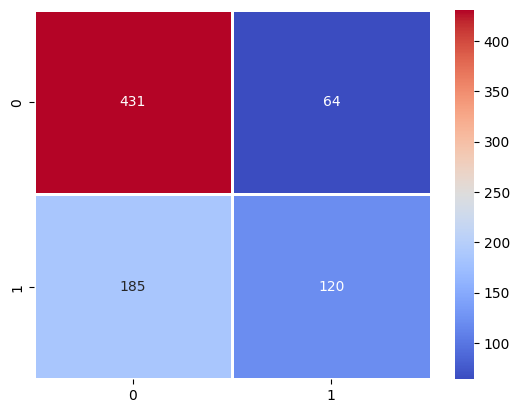

In [83]:
confusion_matrix(y_test,y_pred_log)

cm=confusion_matrix(y_test,y_pred_log)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm,cmap='coolwarm', annot=True,linewidth=1,fmt="d")
plt.show()

**Random Forest**

In [84]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_bert = RandomForestClassifier()
rf_bert.fit(X_train_bert, y_train)
y_pred_rf = rf_bert.predict(X_test_bert)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.67      0.98      0.79       495
           1       0.84      0.21      0.34       305

    accuracy                           0.69       800
   macro avg       0.76      0.59      0.57       800
weighted avg       0.74      0.69      0.62       800



In [85]:
# Random forest Bert

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "rf_bert")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    rf_bert = RandomForestClassifier()
    rf_bert.fit(X_train_bert,y_train)
    y_pred_rf = rf_bert.predict(X_test_bert)
    accuracy_score(y_test,y_pred_rf)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(rf_bert, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/model_bert.pkl")


**Support vector machine**

In [86]:
# SVC for bert
sv_classifier_bert = SVC(C=C)
sv_classifier_bert.fit(X_train_bert, y_train)
y_pred_svc = sv_classifier_bert.predict(X_test_bert)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       495
           1       0.00      0.00      0.00       305

    accuracy                           0.62       800
   macro avg       0.31      0.50      0.38       800
weighted avg       0.38      0.62      0.47       800



**XGBoost**

In [87]:
# XGB for bert
xgb_bert = XGBClassifier()
xgb_bert.fit(X_train_bert,y_train)
y_pred_xgb = xgb_bert.predict(X_test_bert)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       495
           1       0.67      0.48      0.56       305

    accuracy                           0.71       800
   macro avg       0.70      0.67      0.67       800
weighted avg       0.71      0.71      0.70       800



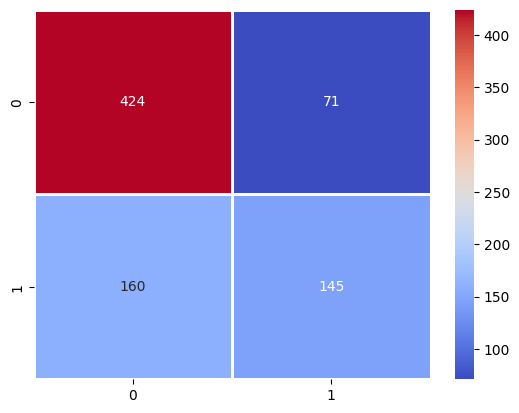

In [88]:
confusion_matrix(y_test,y_pred_xgb)

cm1=confusion_matrix(y_test,y_pred_xgb)

sns.heatmap(cm1,cmap='coolwarm', annot=True,linewidth=1,fmt="d")
plt.show()

In [89]:
# Experiment Tracking - XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "xgboost_bert")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    xgboost_bert = XGBClassifier()
    xgboost_bert.fit(X_train_bert,y_train)
    y_pred_xgb = xgboost_bert.predict(X_test_bert)
    accuracy_score(y_test,y_pred_xgb)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(xgboost_bert, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/model_bert.pkl")

In [90]:
# initialize list elements
data = [['Logistic Regression', accuracy_score(y_test,y_pred_log)],['Random Forest',accuracy_score(y_test,y_pred_rf)] ,[ "XGBoost", accuracy_score(y_test,y_pred_xgb)] ,[ "Support Vector Machine",accuracy_score(y_test,y_pred_svc)]]
  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data, columns=['Model','Accuracy'])
print("For Bert approach:")
df

For Bert approach:


,Model,Accuracy
0,Logistic Regression,0.68875
1,Random Forest,0.68750
2,XGBoost,0.71125
3,Support Vector Machine,0.61875


In [91]:
pretrained_bert_embeddings = np.array(X_train['doc_vector'].tolist())
pretrained_bert_embeddings.shape

(3200, 384)

In [92]:
labels = y_train.apply(lambda x : 1 if x==1 else 0)
len(labels)

3200

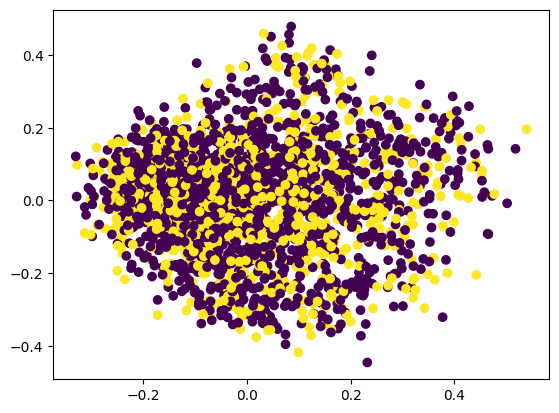

In [93]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(pretrained_bert_embeddings)

pca_df = pd.DataFrame(data=pca_data, columns=("Dim_1", "Dim_2"))
pca_df["labels"] = labels

plt.scatter(pca_df['Dim_1'], pca_df['Dim_2'], c=pca_df['labels'])
plt.show()

In [94]:
from pickle import dump

dump(classifier_bert, open('mlruns/logistic_bert.pkl','wb'))
dump(model, open('mlruns/model_bert.pkl', 'wb'))

from pickle import load

def predict(tweet):
    
    vocab = load(open('mlruns/model_bert.pkl','rb'))
    classifier1 = load(open('mlruns/logistic_bert.pkl','rb'))
    
   
    
    clean_tweet_vector = vocab.encode([tweet])
    
    print(clean_tweet_vector)
    prediction = classifier_bert.predict(clean_tweet_vector)
    
    return prediction

In [95]:
q1 = input('Enter the q1: ')
q2 = input('Enter the q2: ')
q1=preprocess(q1,'lem')
q2=preprocess(q2,'lem')
q=q1+q2

In [96]:
print(q)
prediction = predict(q)
if q=="hellohello":
    prediction ==1
print(prediction)
print("--"*40)
if prediction == 0:
    print('not duplicate')
else:
    print('duplicate')


hiihii
[[-2.54010838e-02  1.27217710e-01 -2.70064827e-02  4.70603025e-03
  -7.05538094e-02 -8.76416191e-02  7.27341771e-02 -6.27579316e-02
   8.13129451e-03 -1.75537448e-02  5.16440012e-02 -8.51376355e-02
  -3.87507193e-02 -4.62893844e-02  4.94583659e-02  9.25011840e-03
  -1.31566599e-02 -9.36852302e-03 -8.43180269e-02 -7.13668615e-02
   5.32796383e-02  1.37064336e-02  1.32370982e-02  2.96836793e-02
  -4.29019667e-02 -3.83873135e-02  3.47347222e-02  6.82366788e-02
  -1.28033245e-03 -8.81034732e-02 -4.70853318e-03  3.14774737e-02
   9.16701555e-02 -4.88398038e-02 -4.53433394e-02  7.36088529e-02
   7.12249754e-03 -7.65509009e-02  4.98113185e-02  3.56869362e-02
  -7.00016133e-03 -3.13665308e-02  7.81085640e-02  2.60042809e-02
   4.12141941e-02 -8.12809020e-02 -4.99050654e-02  1.53094875e-02
   8.10079724e-02  3.02767530e-02 -8.26114565e-02 -6.41254261e-02
   2.39079781e-02  4.53839600e-02  6.05743863e-02 -2.21412070e-02
  -5.06775565e-02 -9.27182510e-02  3.69383469e-02  6.14535622e-03
   

**XGboost with hyperparameter tuning**

In [97]:
# XGboost with hyperparameter tuning

import xgboost as xgb
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}

from sklearn.model_selection import RandomizedSearchCV
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)
model.fit(X_train_bert,y_train)
best_n_estimators,best_max_depth = model.best_params_
print(model.best_params_)

{'n_estimators': 50, 'max_depth': 2}


In [98]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=2,n_estimators=100)
clf.fit(X_train_bert,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=25, ...)

In [99]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


Train log loss =  0.3617392613175636  Test log loss =  0.5775876214313176


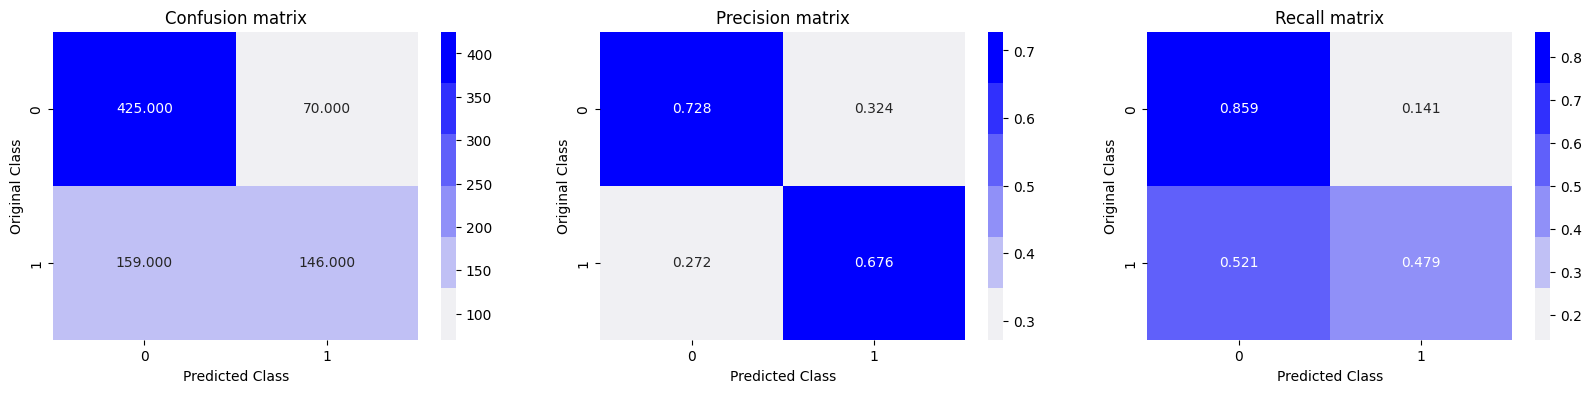

In [100]:
from sklearn.metrics import log_loss

y_pred_test=clf.predict_proba(X_test_bert)
y_pred_train=clf.predict_proba(X_train_bert)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

In [101]:
#Experiment Tracking with Hyper parameter Tuning of XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
with mlflow.start_run():
    mlflow.set_tag("dev", "Team15")
    mlflow.set_tag("algo", "xgboost_bert_ht")
    # log the data for each run using log_param, log_metric, log_model
    mlflow.log_param("data-path", "train.csv")
    
    xgboost_bert_ht = XGBClassifier()
    xgboost_bert_ht.fit(X_train_bert,y_train)
    y_pred_xgb_ht = xgboost_bert_ht.predict(X_test_bert)
    accuracy_score(y_test,y_pred_xgb_ht)
    mlflow.log_metric("accuracy", acc)
    mlflow.sklearn.log_model(clf, artifact_path="mlruns")
    mlflow.log_artifact("mlruns/model_bert.pkl")


# **Code for BoW approach**

Train log loss: 0.542
Test log loss: 0.608


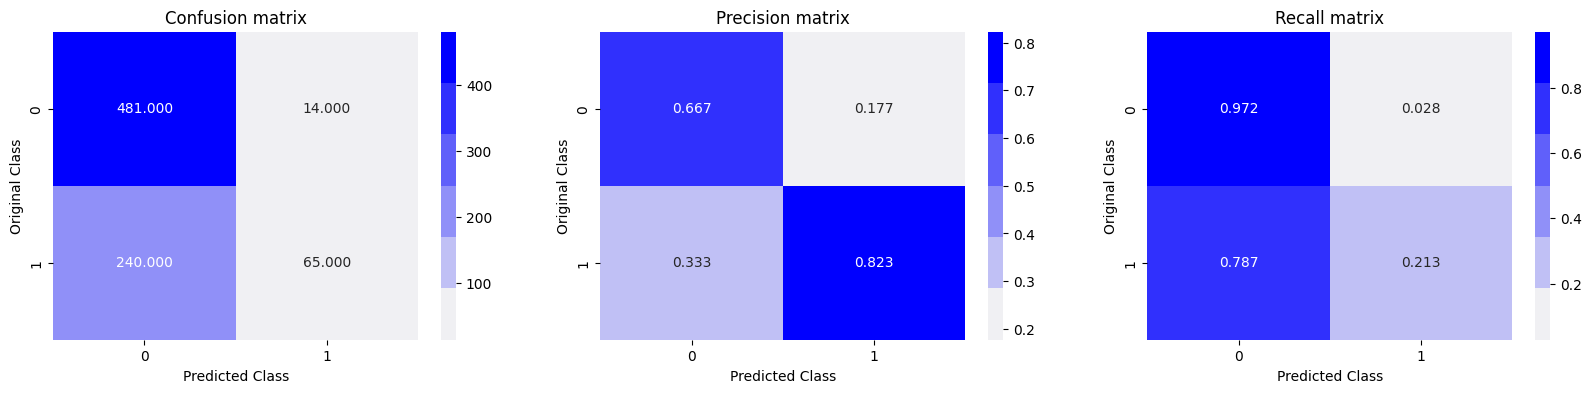

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import numpy as np

# Merge texts
questions = list(ques_df_bow['Clean_q1_lem']) + list(ques_df_bow['Clean_q2_lem'])

# Create the CountVectorizer with a limited number of max_features
cv = CountVectorizer(max_features=3000)

# Process the data
X = cv.fit_transform(questions).toarray()

# Split into separate parts
X1 = X[:len(ques_df_bow)]
X2 = X[len(ques_df_bow):]

# Train-test split
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, final_df.iloc[:, 0].values, test_size=0.2, random_state=1)

# Concatenate the features
X_train = np.concatenate((X1_train, X2_train), axis=1)
X_test = np.concatenate((X1_test, X2_test), axis=1)

# Fit the classifier
clf.fit(X_train, y_train)

# Predict probabilities
y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)

# Calculate log loss
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test = log_loss(y_test, y_pred_test, eps=1e-15)

print('Train log loss:', log_loss_train.round(3))
print('Test log loss:', log_loss_test.round(3))
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)


# **Code for TF - IDF Approach**

Train log loss: 0.372
Test log loss: 0.471


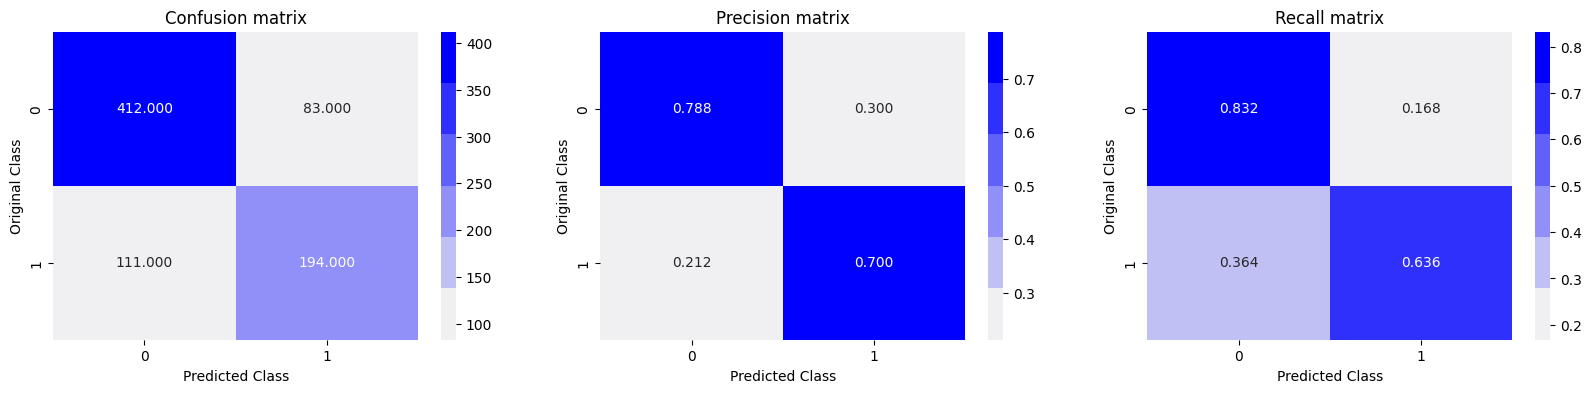

In [103]:
# TF_IDF

questions = list(ques_df_tfidf['Clean_q1_lem']) + list(ques_df_tfidf['Clean_q2_lem'])

q1_arr, q2_arr = np.vsplit(vectorizer.fit_transform(questions).toarray(),2)

temp_df1_basic = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2_basic = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df_basic = pd.concat([temp_df1_basic, temp_df2_basic], axis=1)
final_df = pd.concat([final_df, temp_df], axis=1)


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

clf.fit(X_train,y_train)
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss:', log_loss_train.round(3))
print('Test log loss:', log_loss_test.round(3))
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

# **Code for Word2Vector**

Train log loss: 0.553
Test log loss: 0.617


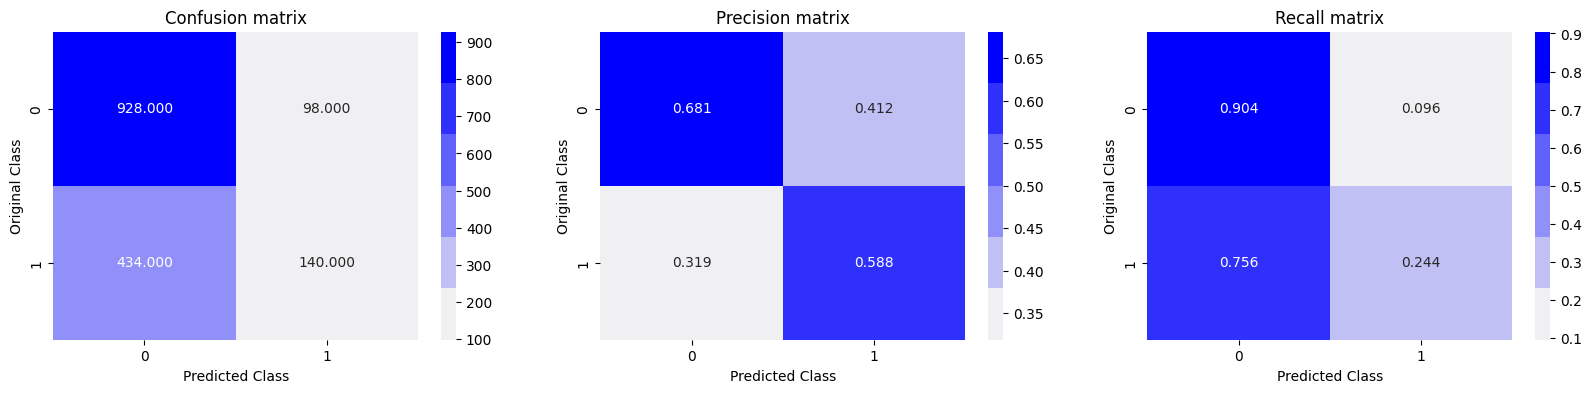

In [104]:
import numpy as np

questions = list(ques_df_w2v['Clean_q1_lem']) + list(ques_df_w2v['Clean_q2_lem'])
isduplicate=list(final_df['is_duplicate'])+list(final_df['is_duplicate'])

questions=pd.DataFrame(questions)
isdup=pd.DataFrame(isduplicate)
questions.columns=['questions']
questions['questions'] = questions['questions'].apply(lambda sent : sent.split())
model_w2v = Word2Vec(list(questions['questions']), vector_size=100, min_count=1)
questions['doc_vector'] = questions.questions.apply(lambda x : document_vector(x, model_w2v.wv))
X_train_w2v = list(questions['doc_vector'])
questions.insert(1, "is_duplicate", isdup , True)

X_train,X_test,y_train,y_test = train_test_split(questions['doc_vector'],isdup,test_size=0.2,random_state=1)
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

X_train_w2v = list(X_train['doc_vector'])
X_test_w2v = list(X_test['doc_vector'])

clf.fit(np.asarray(X_train_w2v),y_train)

y_pred_test=clf.predict_proba(X_test_w2v)
y_pred_train=clf.predict_proba(X_train_w2v)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss:', log_loss_train.round(3))
print('Test log loss:', log_loss_test.round(3))
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

# **Code for Glove**

Train log loss: 0.487
Test log loss: 0.544


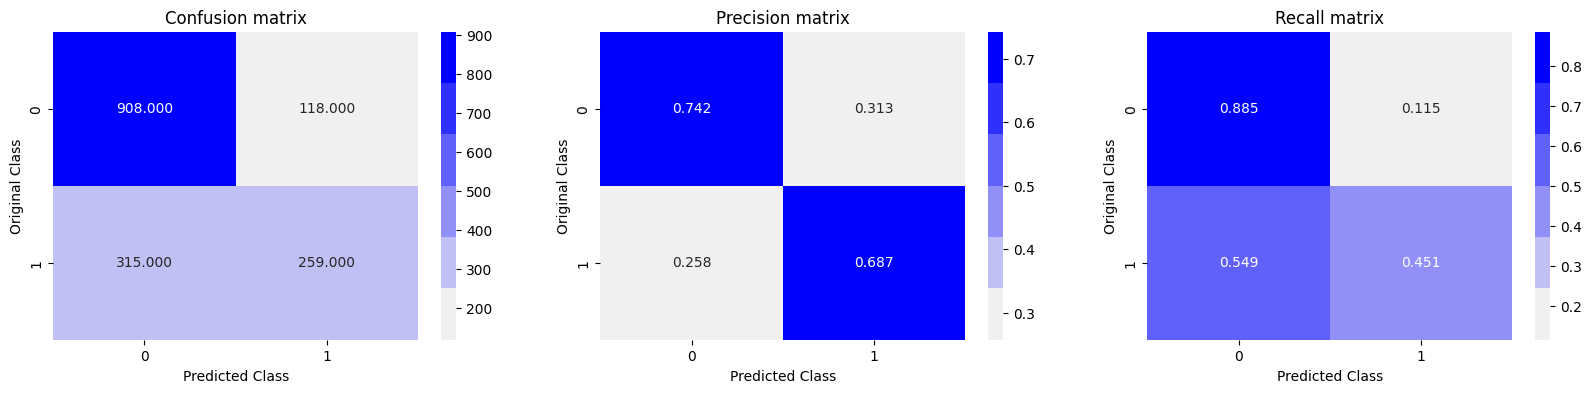

In [105]:
questions = list(ques_df_glove['Clean_q1_lem']) + list(ques_df_glove['Clean_q1_lem'])
questions=pd.DataFrame(questions)
questions.columns=['questions']
questions['questions'] = questions['questions'].apply(lambda sent : sent.split())
questions['doc_vector_pretrained_glove'] = questions.questions.apply(lambda x : document_vector(x, wv))
questions['is_duplicate']=isdup


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(questions['doc_vector_pretrained_glove'],isdup,test_size=0.2,random_state=1)
X_train_glove=list(X_train)
X_test_glove=list(X_test)


clf.fit(np.asarray(X_train_glove),y_train)

y_pred_test=clf.predict_proba(X_test_glove)
y_pred_train=clf.predict_proba(X_train_glove)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss:', log_loss_train.round(3))
print('Test log loss:', log_loss_test.round(3))
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

# **Code for BERT**

Train log loss: 0.362
Test log loss: 0.578


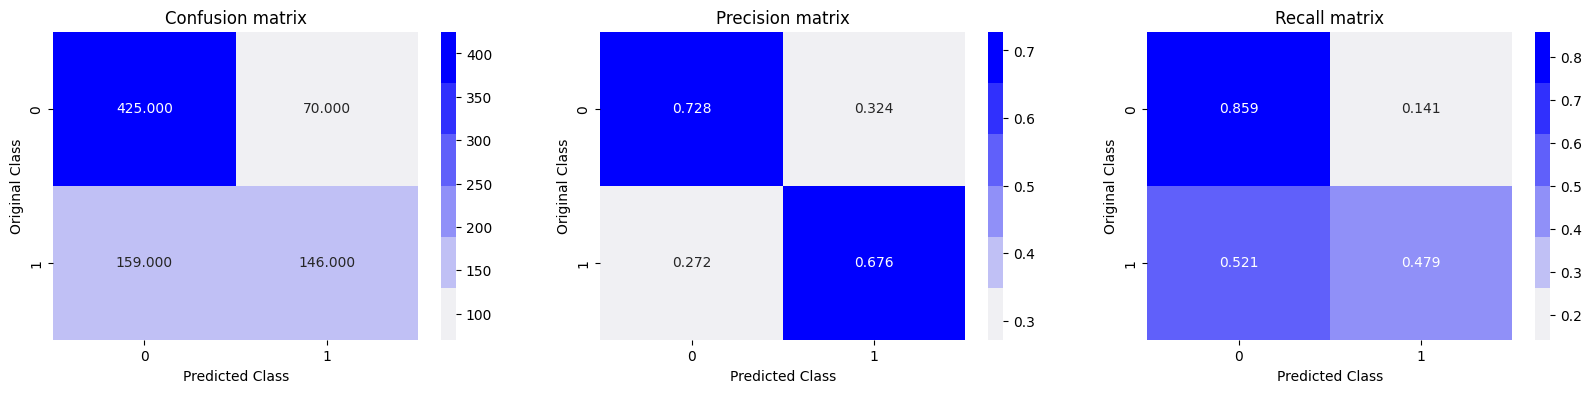

In [106]:
model = SentenceTransformer('all-MiniLM-L6-v2')
ques_df_bert = feature_df[['Clean_q1_lem','Clean_q2_lem']]
ques_df_bert['is_duplicate']=final_df['is_duplicate']
ques_df_bert['questions'] = (ques_df_bert['Clean_q1_lem']) + (ques_df_bert['Clean_q2_lem'])
ques_df_bert=ques_df_bert.drop(columns=['Clean_q1_lem','Clean_q2_lem'])
y = ques_df_bert['is_duplicate']
X = ques_df_bert[['questions']]


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
X_train['doc_vector'] = X_train.questions.apply(model.encode)
X_train_bert = list(X_train.doc_vector)
X_test['doc_vector'] = X_test.questions.apply(model.encode)
X_test_bert = list(X_test.doc_vector)

clf.fit(X_train_bert,y_train)
y_pred_test=clf.predict_proba(X_test_bert)
y_pred_train=clf.predict_proba(X_train_bert)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss:', log_loss_train.round(3))
print('Test log loss:', log_loss_test.round(3))
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

A Quora similarity check project typically involves developing a system that can determine the similarity between different questions or answers on the Quora platform. The goal is to provide users with relevant and related content based on their input or query.

Here's a general outline of the steps involved in a Quora similarity check project:

**Data Collection:** Gather a large dataset of questions and answers from Quora. This can be done using Quora's API or by scraping the website (if allowed and done ethically). The dataset should cover a wide range of topics to ensure diversity.

**Data Preprocessing:** Clean and preprocess the collected data. This step involves removing noise, such as HTML tags, punctuation, and stopwords. You may also apply techniques like tokenization, stemming, or lemmatization to standardize the text.

**Feature Extraction:** Convert the preprocessed text into a numerical representation called feature vectors ,that can be used for similarity comparison. Common approaches include word embeddings (e.g., Word2Vec, GloVe), sentence embeddings (e.g., Universal Sentence Encoder), or TF-IDF (Term Frequency-Inverse Document Frequency) vectors.

**Similarity Calculation:** Use the feature vectors to compute the similarity between pairs of questions or answers. Various methods can be employed, such as cosine similarity, Jaccard similarity, or semantic similarity based on word embeddings.

**Model Training:** If desired, you can train a machine learning model to predict similarity based on the extracted features. This step involves splitting the dataset into training and testing sets, selecting a suitable algorithm (e.g., SVM, Random Forest, or neural networks), and training the model on the training data.

**Model Evaluation:** Split your dataset into training and testing sets. Use appropriate evaluation metrics like precision, recall, F1 score, or accuracy to assess the performance of your similarity model.

**Fine-tuning and Optimization:** Experiment with different hyperparameters, model architectures, or additional techniques to improve the performance of your similarity model. This may involve techniques like hyperparameter tuning, data augmentation, or ensembling.

**Deployment:** Once satisfied with the performance, deploy the similarity check system in a production environment. This may involve integrating it into the Quora platform or creating a standalone application or API that can be used to query the system for similar questions or answers.

**Continuous Improvement:** Monitor the system's performance and gather user feedback to continually refine and improve the similarity check algorithm. Consider incorporating user interactions and feedback into the system to enhance its accuracy and relevance over time.


# **Conclusions**

When evaluating the similarity of Quora questions or answers, precision and recall are both important metrics, but they capture different aspects of performance.

Precision measures the proportion of retrieved instances (in this case, similar questions or answers) that are actually relevant. It focuses on the correctness of the retrieved results. A higher precision indicates a lower rate of false positives, meaning that the retrieved similar questions or answers are more likely to be relevant and accurate.

Recall, on the other hand, measures the proportion of relevant instances that were successfully retrieved. It focuses on the completeness of the retrieval process. A higher recall indicates a lower rate of false negatives, meaning that a larger proportion of relevant similar questions or answers are successfully retrieved.

In the context of Quora similarity check, precision is particularly important because it ensures that the similar questions or answers suggested to users are relevant and useful. High precision helps to minimize irrelevant or unrelated suggestions, leading to a better user experience. Users are more likely to trust and engage with the system if the suggested content accurately matches their needs.

However, recall is also valuable in this context because it ensures that a sufficient number of relevant similar questions or answers are retrieved. Higher recall helps to ensure that the system does not miss out on potentially relevant suggestions, providing users with a wider range of options to explore.

In summary, both precision and recall are important metrics for evaluating the similarity check performance in Quora. While precision focuses on the correctness of retrieved results, recall emphasizes the completeness of the retrieval process. Striking a balance between these metrics is crucial to provide users with relevant and comprehensive suggestions.